In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
base_dir = '../../../dataset/dist-unbalanced/train/'

In [3]:
import os

num_skipped = 0
for folder_name in ("accepted", "rejected"):
    folder_path = os.path.join(base_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
image_size = (180, 180)
batch_size = 64

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 16732 files belonging to 2 classes.
Using 13386 files for training.
Using 3346 files for validation.


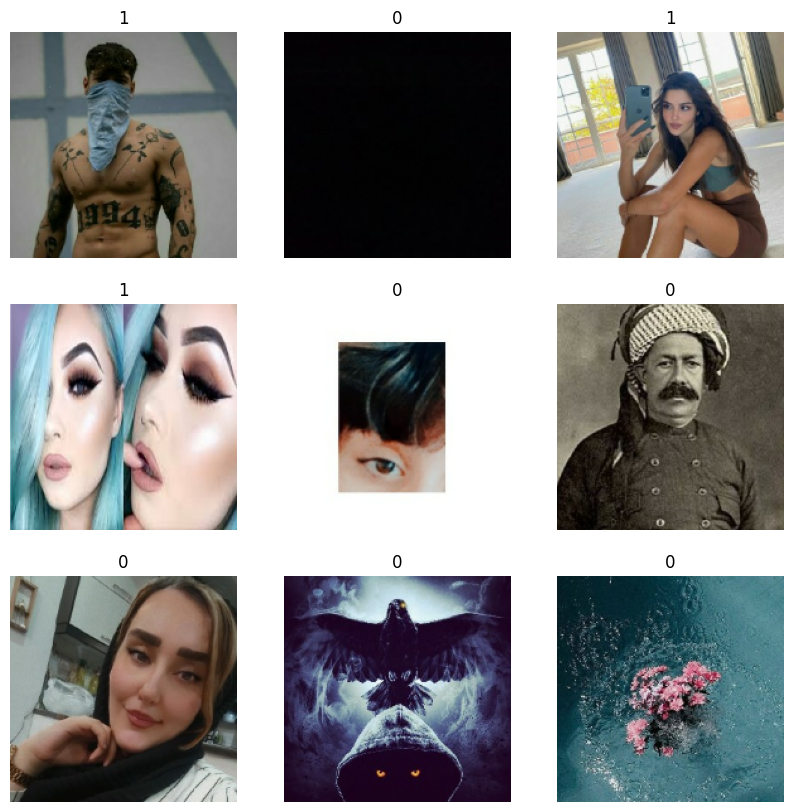

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ]
)

In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
epochs = 500

callbacks = [
    keras.callbacks.ModelCheckpoint("./models/scratch.keras", 
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    mode='max',
                                    verbose=1
                                   ),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/500
210/210 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.6336
Epoch 1: val_accuracy improved from -inf to 0.60550, saving model to ./models/scratch.keras
210/210 [==============================] - 89s 404ms/step - loss: 0.6626 - accuracy: 0.6336 - val_loss: 0.6998 - val_accuracy: 0.6055
Epoch 2/500
210/210 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.6679
Epoch 2: val_accuracy did not improve from 0.60550
210/210 [==============================] - 84s 398ms/step - loss: 0.6333 - accuracy: 0.6679 - val_loss: 0.6949 - val_accuracy: 0.6052
Epoch 3/500
210/210 [==============================] - ETA: 0s - loss: 0.6184 - accuracy: 0.6797
Epoch 3: val_accuracy improved from 0.60550 to 0.61237, saving model to ./models/scratch.keras
210/210 [==============================] - 83s 392ms/step - loss: 0.6184 - accuracy: 0.6797 - val_loss: 0.7158 - val_accuracy: 0.6124
Epoch 4/500
210/210 [==============================] - ETA: 0s - loss

210/210 [==============================] - 80s 379ms/step - loss: 0.4029 - accuracy: 0.8173 - val_loss: 0.6875 - val_accuracy: 0.6871
Epoch 29/500
210/210 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8185
Epoch 29: val_accuracy did not improve from 0.75015
210/210 [==============================] - 81s 383ms/step - loss: 0.3958 - accuracy: 0.8185 - val_loss: 0.5742 - val_accuracy: 0.7421
Epoch 30/500
210/210 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8238
Epoch 30: val_accuracy did not improve from 0.75015
210/210 [==============================] - 81s 385ms/step - loss: 0.3882 - accuracy: 0.8238 - val_loss: 0.5720 - val_accuracy: 0.7391
Epoch 31/500
210/210 [==============================] - ETA: 0s - loss: 0.3834 - accuracy: 0.8283
Epoch 31: val_accuracy improved from 0.75015 to 0.75403, saving model to ./models/scratch.keras
210/210 [==============================] - 80s 379ms/step - loss: 0.3834 - accuracy: 0.8283 - val_loss: 

Epoch 57/500
210/210 [==============================] - ETA: 0s - loss: 0.2507 - accuracy: 0.8972
Epoch 57: val_accuracy did not improve from 0.76599
210/210 [==============================] - 80s 377ms/step - loss: 0.2507 - accuracy: 0.8972 - val_loss: 0.6639 - val_accuracy: 0.7412
Epoch 58/500
210/210 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9009
Epoch 58: val_accuracy did not improve from 0.76599
210/210 [==============================] - 79s 377ms/step - loss: 0.2405 - accuracy: 0.9009 - val_loss: 0.7829 - val_accuracy: 0.7203
Epoch 59/500
210/210 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.8976
Epoch 59: val_accuracy did not improve from 0.76599
210/210 [==============================] - 80s 378ms/step - loss: 0.2453 - accuracy: 0.8976 - val_loss: 0.7204 - val_accuracy: 0.7618
Epoch 60/500
210/210 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9003
Epoch 60: val_accuracy did not improve from 0.7659

Epoch 86/500
210/210 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9391
Epoch 86: val_accuracy did not improve from 0.76599
210/210 [==============================] - 80s 377ms/step - loss: 0.1545 - accuracy: 0.9391 - val_loss: 0.7207 - val_accuracy: 0.7364
Epoch 87/500
210/210 [==============================] - ETA: 0s - loss: 0.1389 - accuracy: 0.9476
Epoch 87: val_accuracy did not improve from 0.76599
210/210 [==============================] - 79s 377ms/step - loss: 0.1389 - accuracy: 0.9476 - val_loss: 1.0047 - val_accuracy: 0.7451
Epoch 88/500
210/210 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9438
Epoch 88: val_accuracy did not improve from 0.76599
210/210 [==============================] - 80s 377ms/step - loss: 0.1410 - accuracy: 0.9438 - val_loss: 0.9361 - val_accuracy: 0.7424
Epoch 89/500
210/210 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9408
Epoch 89: val_accuracy did not improve from 0.7659

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")